# Generate and Prepare Dataset
In this notebook we'll generate our raw dataset of images of spectrograms of ROIs, augment our dataset to  
increase its size, store the dataset info as a yaml file, and serialize it.

We'll also prepare our dataset by augmenting the dataset (shifting the images 10 pixels in a different direction 4   times), convert our images to graycale, making the images square, and organizing the dataset in an appropriate format. 

In [1]:
# dependencies
import pylab
from pylab import *
import wave
import openpyxl
import yaml
import os
import shutil
import _pickle as cpl # import cPickle
import tarfile
from six.moves import cPickle as pickle
from PIL import Image, ImageOps
from IPython.display import display as disp
from IPython.display import Image as Im
from scipy import ndimage
import random

In this notebook, we declare functions to obtain a dataset from an Excel ROI file.  
Dataset will be a dictionary of form:  
{
species:  
    {  
        min_freqs:[list]  
        max_freqs:[list]  
        start_time:[list]  
        end_time:[list]  
        recording name:[list]  
    }  
    ...  
}  
We also have a function to create a simplified dataset of form:
{  
species:  
    {  
        min_freq:val  
        max_freq:val  
        avg_time:val  
        recording name:[list]  
    }  
    ...  
}  
     
We will save these dictionaries as yaml files

### Get relevant info from wav files

In [2]:
def wavInfo(rec_file):
    wav_file = wave.open(rec_file, 'r')
    frames = wav_file.readframes(-1)
    wave_info = pylab.fromstring(frames, 'Int16') #all .wavs in our dataset are 16bit
    framerate = wav_file.getframerate()
    wav_file.close()
    return wave_info, framerate

### Get spectrogram info from a wav file
We'll obtain:  
spectrum: 2-D array of periodograms of succesive  
freqs: frequencies corresponding to rows in spectrum  
t: times of midpoints in segments (columns in spectrum)  

In [3]:
# get info. don't graph
def specInfo(rec_file):
    wave_info, framerate = wavInfo(rec_file)
    spectrum, freqs, t, _ = pylab.specgram(wave_info, NFFT=512, noverlap=256, window=pylab.window_hanning, Fs=framerate)
    del _
    return spectrum, freqs, t
    #pylab.savefig("%s_spectrogram.png" % rec_file)

### Obtain the bounds of the spectrogram ROI we're going to build
We'll use a modified binary search to find the rightmost and leftmost values that meet our conditions. 

In [4]:
# search for the index of the leftmost value in an ordered array 
# (of times or frequencies in our case) that still meet our criteria
def leftmostBinSearch(A, lo, hi, target):
    mid = (lo + hi) // 2
    v1 = A[mid]
    if (v1 >= target):
        if (mid > 0 and A[mid - 1] > target):
            return leftmostBinSearch(A, lo, mid-1, target)
        else:
            return mid
    elif (A[mid] < target):
        return leftmostBinSearch(A, mid+1, hi, target)
    else:
        return leftmostBinSearch(A, lo, mid-1, target)

# search for the index of the rightmost value in an ordered array 
# (of times or frequencies in our case) that still meet our criteria
def rightmostBinSearch(A, lo, hi, target): 
    mid = (lo + hi) // 2
    v1 = A[mid]
    if (v1 <= target):
        if (mid < (len(A) - 1) and A[mid + 1] <= target):
            return rightmostBinSearch(A, mid+1, hi, target)
        else:
            return mid
    elif (A[mid] < target):
        return rightmostBinSearch(A, mid+1, hi, target)
    else:
        return rightmostBinSearch(A, lo, mid-1, target)

In [5]:
def getBounds(A, minVal, maxVal):
    left = leftmostBinSearch(A, 0, len(A)-1, minVal)
    right = rightmostBinSearch(A, 0, len(A)-1, maxVal)
    return left, right

### Build spectrograms of ROI's
Returns the spectrum matrix with only the values we're interested in.

In [6]:
# get modified spectrum of frequencies and times that matter to us
def specMod(spectrum, freqs, times, f1, f2, t1, t2):
    spectrumMod = [spectrum[f1][t1:t2]]
    for f in range(f1+1, f2):
            spectrumMod = spectrumMod + [spectrum[f][t1:t2]]
    return spectrumMod

In [7]:
# based off: http://stackoverflow.com/questions/15961979/how-do-i-plot-a-spectrogram-the-same-way-that-pylabs-specgram-does
# plot the spectrogram of our region of interest
def plotModSpecSimple(specMod, freqs, times, file):
    
    fig, ax = pylab.subplots(1)
    pylab.pcolormesh(times, freqs, 10 * pylab.log10(specMod))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('tight')
    ax.axis('off')
    pylab.savefig(file)
    return fig

In [8]:
def speciesData(workbook):
    roi_ws = openpyxl.load_workbook(workbook)['ROIs'] # should change accordingly to where and how you data is stored
    dataset = {}
    # needed format:
    # species specimen per row
    # columns: species name, start_time, end_time, min_freq, max_freq, recording name
    # columns A to F
    sheetMatrix = list(roi_ws.iter_rows())
    # remove row with column names and create array of keys per species. (e.g. start_time, end_time, ...)
    keys = sheetMatrix.pop(0) 
    for row in sheetMatrix:
        speciesName = row[0].value
        if (speciesName not in dataset):
            dataset[speciesName] = {}
        for col in range(1,len(row)):
            cell = ''
            # change recording extension since we are dealing with wav files
            if (col == 5):
                cell = row[col].value.split('.')[0]
                cell += '.wav'
            else:
                cell = row[col].value
            # if per species key is not present add the key and add the value as the first element in a list
            if (keys[col].value not in dataset[speciesName]): 
                dataset[speciesName][keys[col].value] = [cell]
            # append to the list of attributes 
            else:
                dataset[speciesName][keys[col].value] = dataset[speciesName][keys[col].value] + [cell]
    return dataset

In [9]:
def dataToYAML(data, name): # convert speciesData dictionary to yaml and save file
    # need to check if file exists then delete it
    path = '../dataset/' + name
    dataset = open(path, 'w+')
    dump = yaml.dump(data, dataset, default_flow_style=False)
    dataset.close()

In [10]:
def findMax(L):
    Max = float('-inf')
    for n in L:
        if (n > Max):
            Max = n
    return Max

def findMin(L):
    Min = float('inf')
    for n in L:
        if (n < Min):
            Min = n
    return Min

In [11]:
# save our species data dictionary as a .yaml file for later use
workbook = '../dataset/validationsAndROIs.xlsx'
data = speciesData(workbook)
dataToYAML(data, 'dataset.yaml')
#simpleData = simplifiedSpeciesData(data)
#dataToYAML(simpleData, 'simplifiedDataset.yaml')

### Generate our dataset
Now we'll use our previous functions to go through our generated dictionary and create a  
Raw unprocessed dataset of spectrogram of ROIs in appropriate directories per species  
and returning our dataset as a 2D array of dictionaries that contain our images.  

In [12]:
def getRawSpecDataset(dataset, path='../dataset'):
    
    # make directory to store our spec dataset
    dataset_path = path + '/spectrogram_roi_dataset'
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    else:
        shutil.rmtree(dataset_path)
        os.makedirs(dataset_path)
    species = dataset.keys()
    
    # image data to be pickled 
    specs = {}
    
    for s in species:
        s_dir = dataset_path + '/' + s
        s_spec = []
        os.makedirs(s_dir) # make a directory per species
        
        # load species ROI data
        min_freqs = dataset[s]['min_frequency']
        max_freqs = dataset[s]['max_frequency']
        starts = dataset[s]['start_time']
        ends = dataset[s]['end_time']
        recs = dataset[s]['recording name']
        
        for i in range(0, len(recs)):
            rec = '../dataset/recordings/' + recs[i] # path to ith recording file where s is present
            spectrum, freqs, times = specInfo(rec) # get entire spectrogram data from rec
            
            # get ROI info in rec
            t_0 = starts[i] 
            t_n = ends[i]
            f_0 = min_freqs[i]
            f_n = max_freqs[i]
            
            # find closest times and freqs that match ROI info
            t_start, t_end = getBounds(times, t_0, t_n)
            f_start, f_end = getBounds(freqs, f_0, f_n)
            
            # get modified spectrum, freqs, and times
            spectrumMod = specMod(spectrum, freqs, times, f_start, f_end, t_start, t_end)
            freqMod = freqs[f_start:f_end]
            timeMod = times[t_start:t_end]
            filename = s_dir + '/' + s + '_spec_' + str(i+1) + '.png'
            
            # plot the spectrogram of ROI and save the image 
            f = plotModSpecSimple(spectrumMod, freqMod, timeMod, filename)
            s_spec.append(f) # append image to list of ROI spectrograms per species
            plt.close()
            #pylab.close
        
        # update our dictionary with key <species_name> and value <list_of_spectrogram_figures>
        specs[s] = s_spec
    
    return specs

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  after removing the cwd from sys.path.


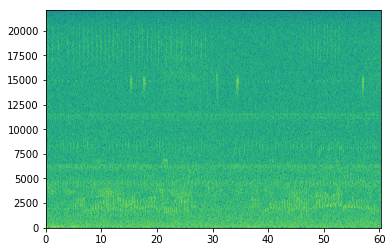

In [13]:
yamlData = open('../dataset/dataset.yaml', 'r')
dataset = yaml.load(yamlData)
yamlData.close()
data = getRawSpecDataset(dataset)

Finally, we'll package our dataset in a more manageble format by:  
* archiving and compressing our dataset directory into a .tar.bz2 file
* serializing our dataset object into a folder of pickles (was recieving errors when  
  I tried to serialize the whole object. maybe too big?)

In [14]:
def serializeDataset(obj, path='../dataset'):
    pickle_path = path + '/pickle_data'
    # create pickle directory if exists, else overwrite it
    if not os.path.exists(pickle_path):
        os.makedirs(pickle_path)
    else:
        shutil.rmtree(pickle_path)
        os.makedirs(pickle_path)
    for s in obj.keys():
        data = obj[s]
        picklename = pickle_path + '/' + s + '.pickle'
        with open(picklename, 'wb+') as pn:
            cpl.dump(data, pn)

### Processing of Dataset
Here we'll process our dataset by changing the image dimmensions to a square and converting them to grayscale.

In [15]:
#archiveAndCompress('../dataset/spectrogram_roi_dataset')
#archiveAndCompress('../dataset/pickle_data')

Running these functions should result in:
* .yaml file that contains the structure of our dataset
* a spectrogram_roi_dataset directory that contains directories of species and their ROI spectrograms
* a spectrogram_roi_dataset.tar.bz2
* a pickle_data direcrory that contains a pickle of the ROI spectrograms of each species
* a pickle_data.tar.bz2  

In [16]:
def squareAndGrayImage(image, size, path, species, name):
    # open our image and convert to grayscale 
    # (needed since color channels add a third dimmension)
    im = image.convert('L')
    # dimmensions of square image
    size = (size,size)
    # resize our image and adjust if image is not square. save our image
    proc_image = ImageOps.fit(im, size, Image.ANTIALIAS)
    proc_image.save(path + '/' + species + '/squared_' + name)
    return proc_image
    #print(ndimage.imread(path + '/' + species + '/squared_' + name).shape)

### Augment Dataset
Here we'll increase the size of our dataset by augmenting our current dataset.  
We'll do this by shifting each image 10 pixels up, left, down, and right independently.  

All credit to the augmentation code goes to my lab partner, [Ian Flores](https://github.com/ian-flores/Deep-Learning-Species-Identification/).  

In [17]:
def augmentAndProcessDataset(raw_dataset_path, processed_dataset_path):
    
    # this may have some solutions for more efficient shifting where we can 
    # add values to not zero out part of our image:
    # https://stackoverflow.com/questions/30399534/shift-elements-in-a-numpy-array
    
    shift = ndimage.interpolation.shift
    
    if not os.path.exists(processed_dataset_path):
        os.makedirs(processed_dataset_path)
    else:
        shutil.rmtree(processed_dataset_path)
        os.makedirs(processed_dataset_path)
    
    for species in os.listdir(raw_dataset_path):
        s_images = os.listdir(raw_dataset_path + '/' + species)
        os.makedirs(processed_dataset_path + '/' + species)
        for image in s_images:
            og_im = Image.open(raw_dataset_path + '/' + species + '/' + image)
            proc_im = squareAndGrayImage(og_im, 100, processed_dataset_path, species, 'processed_og_'+image)
            im = np.asarray(proc_im, dtype=np.float32)
            # consult Ian. was doing 11 shifts
            # consult about direction. produced files may be mislabeled
            # values are being zeroed out. may be a concern since 
            # 10 pixel shift with 10 pixels zeroed out means we're losing 1-10%
            # of the image's data. could be as simple as making the images larger
            for i in range(1,11):
                format_im = im.reshape((100,100))
                
                im_left = shift(format_im, [-i,0])
                im_left = Image.fromarray(im_left)
                squareAndGrayImage(im_left, 100, processed_dataset_path, species, 'processed_left_sh_'+str(i)+'_'+image)
                
                im_up = shift(format_im, [0,-i])
                im_up = Image.fromarray(im_up)
                squareAndGrayImage(im_up, 100, processed_dataset_path, species, 'processed_up_sh_'+str(i)+'_'+image)
                
                im_right = shift(format_im, [i,0])
                im_right = Image.fromarray(im_right)
                squareAndGrayImage(im_right, 100, processed_dataset_path, species, 'processed_right_sh_'+str(i)+'_'+image)
                
                im_down = shift(format_im, [0,i])
                im_down = Image.fromarray(im_down)
                squareAndGrayImage(im_down, 100, processed_dataset_path, species, 'processed_down_sh_'+str(i)+'_'+image)

In [18]:
# generate our processed dataset
raw_dataset = '../dataset/spectrogram_roi_dataset'
processed_dataset_path = '../dataset/processed_roi_dataset'
augmentAndProcessDataset(raw_dataset, processed_dataset_path)

### Let's display a sample per class

Here's a random sample from each class in the training dataset:
Eleutherodactylus juanariveroi sample :


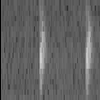

Saltator grossus sample :


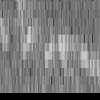

Formicarius analis sample :


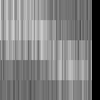

Unknown Insect sample :


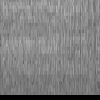

Eleutherodactylus cochranae sample :


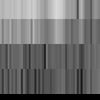

Epinephelus guttatus sample :


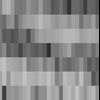

Chlorothraupis carmioli sample :


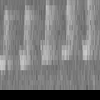

Eleutherodactylus coqui sample :


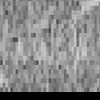

Megascops guatemalae sample :


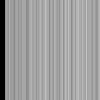

Basileuterus chrysogaster sample :


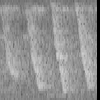

Myrmeciza hemimelaena sample :


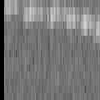

Myrmoborus leucophrys sample :


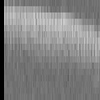

Percnostola lophotes sample :


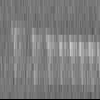

Liosceles thoracicus sample :


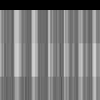

Megascops nudipes sample :


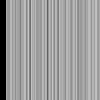

Eleutherodactylus cooki sample :


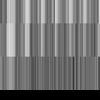

Basileuterus bivittatus sample :


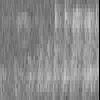

Eleutherodactylus brittoni sample :


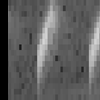

Hypocnemis subflava sample :


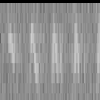

Microcerculus marginatus sample :


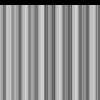

Thamnophilus schistaceus sample :


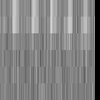

In [19]:
# function for displaying a random photo from each class in a dataset
def displaySamples(dataset_folders):
    # go through each class in the dataset
    dataset = os.listdir(dataset_folders)
    for folder in dataset:
        imgs_path = dataset_folders + '/' + folder
        # list all images in a class
        imgs = os.listdir(imgs_path) 
        # path for a random image from a dataset class
        sample = dataset_folders + '/' + folder + '/' + imgs[np.random.randint(0,len(imgs))] 
        name = sample.split('/')[-2]
        print(name, 'sample :')
        disp(Im(sample)) # display our sample

print("Here's a random sample from each class in the training dataset:")
displaySamples(processed_dataset_path)

### Now we'll obtain a list of class folders

In [20]:
def getDatasetFolders(dataset_path):
    folders = os.listdir(dataset_path)
    dataset_folders = []
    for folder in folders:
        dataset_folders.append(dataset_path + '/' + folder)
    return dataset_folders

dataset_folders = getDatasetFolders(processed_dataset_path)
#print(dataset_folders)

### Here we'll generate a pickle for each class 

In [21]:
image_size = 100  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_image(folder, min_num_images):
    # Load the data for a single species.
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    num_images = 0

    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            #print(image_data.shape)
            # our images are RGBA so we would expect shape MxNx4
            # see: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.imread.html
            if (image_data.shape != (image_size, image_size)):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))

#     print('Full dataset tensor:', dataset.shape)
#     print('Mean:', np.mean(dataset))
#     print('Standard deviation:', np.std(dataset))
    return dataset

def maybe_pickle(data_folders, min_num_images_per_class, pickles_path, force=False):
    
    if not os.path.exists(pickles_path):
        os.makedirs(pickles_path)
    else:
        shutil.rmtree(pickles_path)
        os.makedirs(pickles_path)
  
    dataset_names = []
    for folder in data_folders:
        class_name = folder.split('/')[-1] # species name
        set_filename = pickles_path + '/' + class_name + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_image(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

min_imgs_per_class = 5
pickles_path = '../dataset/pickle_data'
datasets = maybe_pickle(dataset_folders, min_imgs_per_class, pickles_path)

Pickling ../dataset/pickle_data/Eleutherodactylus juanariveroi.pickle.
Pickling ../dataset/pickle_data/Saltator grossus.pickle.
Pickling ../dataset/pickle_data/Formicarius analis.pickle.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  del sys.path[0]


Pickling ../dataset/pickle_data/Unknown Insect.pickle.
Pickling ../dataset/pickle_data/Eleutherodactylus cochranae.pickle.
Pickling ../dataset/pickle_data/Epinephelus guttatus.pickle.
Pickling ../dataset/pickle_data/Chlorothraupis carmioli.pickle.
Pickling ../dataset/pickle_data/Eleutherodactylus coqui.pickle.
Pickling ../dataset/pickle_data/Megascops guatemalae.pickle.
Pickling ../dataset/pickle_data/Basileuterus chrysogaster.pickle.
Pickling ../dataset/pickle_data/Myrmeciza hemimelaena.pickle.
Pickling ../dataset/pickle_data/Myrmoborus leucophrys.pickle.
Pickling ../dataset/pickle_data/Percnostola lophotes.pickle.
Pickling ../dataset/pickle_data/Liosceles thoracicus.pickle.
Pickling ../dataset/pickle_data/Megascops nudipes.pickle.
Pickling ../dataset/pickle_data/Eleutherodactylus cooki.pickle.
Pickling ../dataset/pickle_data/Basileuterus bivittatus.pickle.
Pickling ../dataset/pickle_data/Eleutherodactylus brittoni.pickle.
Pickling ../dataset/pickle_data/Hypocnemis subflava.pickle.
Pi

### Now we'll check if our dataset is balanced 

In [22]:
# let's fetch our pickles
pickles = getDatasetFolders('../dataset/pickle_data') 

In [23]:
def class_is_balanced(pickles):
    total = 0
    for pckle in pickles:
        if (os.path.isfile(pckle)):
            pickle_class = pickle.load(open(pckle, "rb"))
        else:
            print("Error reading dataset %s. Exiting.", pickle_path)
            return -1
        class_name = pckle.split('/')[-1].split('.')[0]
        print("The total number of images in class %s is: %d" % (class_name, len(pickle_class)))
        total += len(pickle_class)
    print("For the dataset to be balanced, each class should have approximately %d images.\n" % (total / len(pickles)))
    return (total // len(pickles))
    
print("Let's see if the dataset is balanced:")
balance_num = class_is_balanced(pickles)

Let's see if the dataset is balanced:
The total number of images in class Basileuterus bivittatus is: 615
The total number of images in class Microcerculus marginatus is: 492
The total number of images in class Epinephelus guttatus is: 697
The total number of images in class Eleutherodactylus cooki is: 656
The total number of images in class Eleutherodactylus juanariveroi is: 205
The total number of images in class Chlorothraupis carmioli is: 451
The total number of images in class Saltator grossus is: 410
The total number of images in class Basileuterus chrysogaster is: 205
The total number of images in class Percnostola lophotes is: 697
The total number of images in class Unknown Insect is: 410
The total number of images in class Eleutherodactylus cochranae is: 1025
The total number of images in class Hypocnemis subflava is: 984
The total number of images in class Megascops guatemalae is: 246
The total number of images in class Formicarius analis is: 451
The total number of images in

In [24]:
def getLargestClass(pickles):
    num_images = 0
    class_info = []
    for index,pckle in enumerate(pickles):
        if (os.path.isfile(pckle)):
            pickle_class = pickle.load(open(pckle, "rb"))
        else:
            print("Error reading dataset %s. Exiting.", pickle_path)
            return -1
        class_name = pckle.split('/')[-1].split('.')[0]
        if(len(pickle_class) > num_images):
            num_images = len(pickle_class)
            class_info = [index, class_name, num_images]
            
    print("Largest dataset is {} with {} images".format(class_info[1], class_info[2]))
    return class_info

class_info = getLargestClass(pickles)

Largest dataset is Myrmeciza hemimelaena with 1886 images


### Choose subset of dataset classes
Since our dataset is not balanced and we want to test all classes we'll choose the smallest  
one and pick the same amount from the other classes

In [25]:
# try: let's see if with our new augmented dataset we can choose the smallest classt
# and choose that amount of images from the other classes 
# you can find the min number of images with a trivial function like this:

def findMinClass(dataset_path):
    minm = float('inf')
    species = ''
    for folder in dataset_folders:
        images= os.listdir(folder)
        count = len(images)
        if (count < minm): 
            minm = count
            species = folder.split('/')[-1]

    return (species, minm)

In [26]:
min_class = findMinClass(dataset_folders)
print(min_class)

('Eleutherodactylus juanariveroi', 205)


In [27]:
# go through our pickles, load them, shuffle them, and choose class_size amount of the images
def makeSubClasses(class_size, pickle_path, pickle_files):
    
    # create path for folder of pickles of subsets of classes
    if not os.path.exists(pickle_path):
        os.makedirs(pickle_path)
    else:
        shutil.rmtree(pickle_path)
        os.makedirs(pickle_path)
    
    # list of pickles of subsets of classes
    subclasses = []
    
    for pickle_file in pickle_files:
        try:
            with open(pickle_file, 'rb') as f:
                name = pickle_path + pickle_file.split('/')[-1].split('.')[0] + '_subset.pickle'
                species_set = pickle.load(f) # set of images from species
                # let's shuffle the letters to have random subset
                np.random.shuffle(species_set)
                species_set = species_set[:class_size,:,:]
                try:
                    with open(name, 'wb') as f:
                        pickle.dump(species_set, f, pickle.HIGHEST_PROTOCOL)
                        subclasses.append(name)
                except Exception as e:
                    print('Unable to save data to', name, ':', e)
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            pass
    return subclasses

In [28]:
pickle_sublasses = makeSubClasses(min_class[1], '../dataset/subclasess_pickle_data/', pickles)
#print(pickle_sublasses)

### Create datasets

In [29]:
# our dataset is now balanced. calculate our training, validation, and test dataset sizes
total_images = len(pickle_sublasses) * min_class[1]
print("We have a total of {}.".format(total_images))
print("We'll split them 50/20/30 for training, validation, and testing respectively.")
print("Training dataset size: {}".format(int(total_images*0.5)))
print("Validation dataset size: {}".format(int(total_images*0.2)))
print("Testing dataset size: {}".format(int(total_images*0.3)))

We have a total of 4305.
We'll split them 50/20/30 for training, validation, and testing respectively.
Training dataset size: 2152
Validation dataset size: 861
Testing dataset size: 1291


In [30]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets_all(pickle_files, train_size, valid_size, test_size): # valid_size is 0 if not given as argument. 
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    test_dataset, test_labels = make_arrays(test_size, image_size)

    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    tesize_per_class = test_size // num_classes
    
    start_v, start_t, start_te = 0, 0, 0
    end_v, end_t, end_te= vsize_per_class, tsize_per_class, tesize_per_class
    end_l = vsize_per_class + tsize_per_class
    end_tst = end_l + tesize_per_class
    

    for label, pickle_file in enumerate(pickle_files):
        #print(start_v, end_v)
        #print(start_t, end_v)
        name = (pickle_file.split('/')[-1]).split('.')[0]
        try:
            with open(pickle_file, 'rb') as f:
                species_set = pickle.load(f) # set of images from species
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(species_set) # shuffle the data (the "images") in the pickle around 
                

                #print("Valid dataset with", name, ". Has ", len(species_set), " images.")
                #print("Needs %d images per class" % vsize_per_class)
                #print("valid_species is species_set[:%d,:,:]" % vsize_per_class)
                valid_species = species_set[:vsize_per_class, :, :]
                #print("valid_dataset[%d:%d,:,:] = valid_species" % (start_v,end_v))
                valid_dataset[start_v:end_v, :, :] = valid_species
                #print("valid_labels[%d:%d] = %d" % (start_v,end_v,label))
                valid_labels[start_v:end_v] = label
                start_v += vsize_per_class
                end_v += vsize_per_class


                #print("Train dataset with", name, ". Has ", len(species_set), " images")
                #print("Needs %d images per class" % tsize_per_class)
                #print("train_species is species_set[%d:%d,:,:]" % (vsize_per_class,end_l))
                train_species = species_set[vsize_per_class:end_l, :, :]
                #print("train_dataset[%d:%d,:,:] = train_species" % (start_t,end_t))
                train_dataset[start_t:end_t, :, :] = train_species
                #print("train_labels[%d:%d] = %d" % (start_t,end_t,label))
                train_labels[start_t:end_t] = label # give label to all images in class    
                start_t += tsize_per_class # offset start of class for next iteration 
                end_t += tsize_per_class # offset end of class for next iteration
                
                #print("Test dataset with", name, ". Has ", len(species_set), " images")
                #print("Needs %d images per class" % tesize_per_class)
                #print("test_species is species_set[%d:%d,:,:]" % (end_l, end_te))
                test_species = species_set[end_l:end_tst, :, :]
                #print("test_dataset[%d:%d,:,:] = test_species" % (start_te,end_te))
                test_dataset[start_te:end_te, :, :] = test_species
                #print("test_labels[%d:%d] = %d" % (start_te,end_te,label))
                test_labels[start_te:end_te] = label # give label to all images in class
                start_te += tesize_per_class # offset start of class for next iteration 
                end_te += tesize_per_class # offset end of class for next iteration
                
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            pass
    
    return valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, test_labels

In [31]:
train_size = int(total_images * 0.5)
valid_size = int(total_images * 0.2)
test_size = int(total_images * 0.3)
valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, test_labels = merge_datasets_all(pickle_sublasses, train_size, valid_size, test_size)
#print(train_dataset.shape)

In [32]:
def genLabelMap(pickle_files):
    label_map = {}
    for label, pickle_file in enumerate(pickle_files):
        name = (pickle_file.split('/')[-1]).split('.')[0]
        label_map[label] = name
    return label_map

def sampleCheck(dataset, labels, label_map):
    i = random.randint(1, 5)
    for p_i, img in enumerate(random.sample(range(len(labels)), 5*i)):
        plt.subplot(i, 5, p_i+1)
        plt.axis('off')
        label = labels[img]
        species = label_map[label]
        #print(species)
        title =  species + ' sample:'
        plt.title(title)
        plt.imshow(dataset[img])
        plt.show()

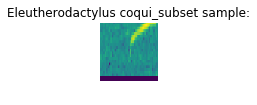

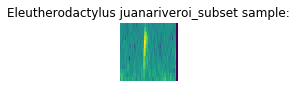

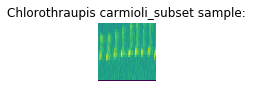

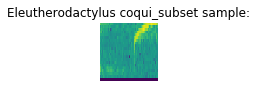

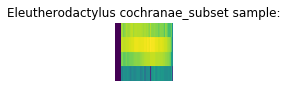

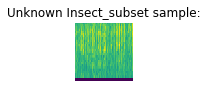

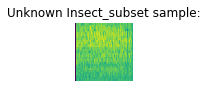

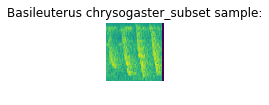

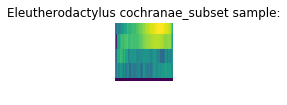

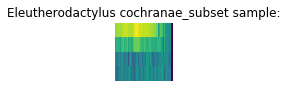

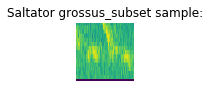

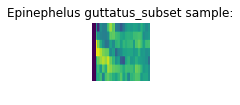

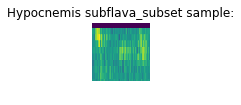

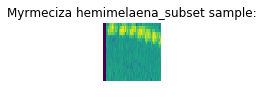

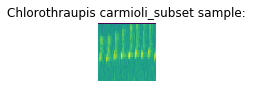

In [33]:
label_map = genLabelMap(pickle_sublasses)
sampleCheck(train_dataset, train_labels,label_map)

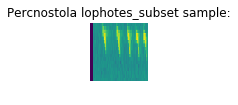

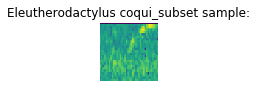

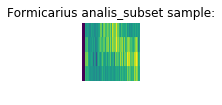

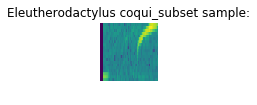

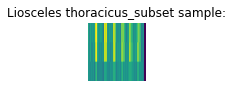

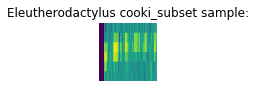

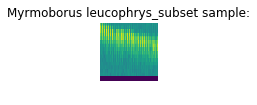

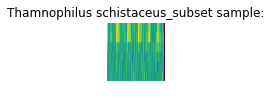

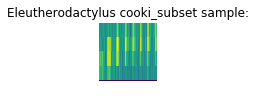

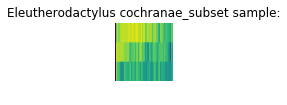

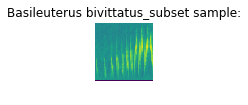

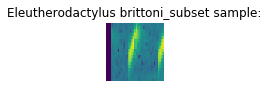

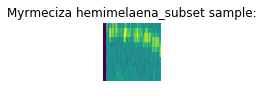

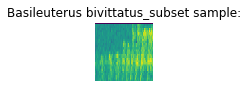

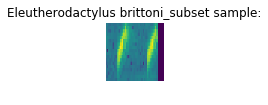

In [34]:
sampleCheck(valid_dataset, valid_labels, label_map)

In [36]:
#pickle_file = '../dataset/arbimonBalanced.pickle'

def saveDataset(pickle_file, train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels):
    try:
        f = open(pickle_file, 'wb')
        
        save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
        } 
        trD = {0:0,1:0}
        for i in train_labels:
            if(i == 0):
                trD[0] += 1
            elif(i == 1):
                trD[1] += 1
        
        print("0 label num: ", trD[0])
        print("1 label num: ", trD[1])
        if (trD[0] == trD[1]):
            print("{} training dataset is balanced".format(pickle_file))
        else:
            print("{} training dataset is NOT balanced".format(pickle_file))
        
        v = {0:0,1:0}
        for i in valid_labels:
            if(i == 0):
                v[0] += 1
            elif(i == 1):
                v[1] += 1
        
        print("0 label num: ", v[0])
        print("1 label num: ", v[1])
        if (v[0] == v[1]):
            print("{} valid dataset is balanced".format(pickle_file))
        else:
            print("{} valid dataset is NOT balanced".format(pickle_file))
            
        teD = {0:0,1:0}
        for i in test_labels:
            if(i == 0):
                teD[0] += 1
            elif(i == 1):
                teD[1] += 1
        
        print("0 label num: ", teD[0])
        print("1 label num: ", teD[1])
        if (teD[0] == teD[1]):
            print("{} test dataset is balanced".format(pickle_file))
        else:
            print("{} test dataset is NOT balanced".format(pickle_file))
            
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL) # save all out datasets in one pickle 
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

In [37]:
#saveDataset('../dataset/arbimonBalanced.pickle', train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels)

In [40]:
# since our current NN uses softmax function for assignment of labels
# for it's output we're trying out binary classification: x species or not x

def binaryPickles(bin_pickle_path, pickles, size):
    
    # the folders where our pickles will be stored
    bin_pickles_folders = []
    
    # a dictionary mapping a species to the total size of it's binary dataset
    class_size_total = {}
    
    # create the dir where our dirs of bin pickles will be stored
    if (not os.path.exists(bin_pickle_path)):
        os.makedirs(bin_pickle_path)
    else:
        shutil.rmtree(bin_pickle_path)
        os.makedirs(bin_pickle_path)
    
    # go through all our pickles and create 2 pickles:
    # one of the current species and another with equal length of shuffled images
    # from the rest of the species
    for pickle_file in pickles:
        name = '/bin_' + pickle_file.split('/')[-1].split('.')[0] + '_pickles'
        
        try:
            with open(pickle_file, 'rb') as f:
                pickle_data = pickle.load(f)
                f.close()
                
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
        
        if not os.path.exists(bin_pickle_path + name):
            os.makedirs(bin_pickle_path + name)
        else:
            shutil.rmtree(bin_pickle_path + name)
            os.makedirs(bin_pickle_path + name)
        
        rest = np.ndarray(shape=(1,size,size), dtype=float)
        
        # go through all the pickles, ignore the current one,
        # open each of the other pickles and concatenate them into one
        for other in pickles:
            
            if (other == pickle_file):
                pass
            try:
                with open(other, 'rb') as f:
                    spec = pickle.load(f)
                    f.close()
                    try:
                        rest = np.concatenate((rest, spec))
                    except Exception as e:
                        print("Unable to merge pickle {} with the rest: {}".format(other,e))
                        raise
            except Exception as e:
                print('Unable to process data from', pickle_file, ':', e)
                raise
        # skip the first fake image, shuffle our images, then choose 
        # the same amount as our species pickle
        rest = rest[1:,:,:]
        np.random.shuffle(rest)
        rest = rest[:len(pickle_data),:,:]
        
        pickle_name = pickle_file.split('/')[-1]
        
        species_filename = bin_pickle_path + name + '/' + pickle_name
        rest_filename = bin_pickle_path + name + '/not_' + pickle_name
        
        print("Species pickle has shape {}".format(pickle_data.shape))
        print("Rest pickle has shape {}".format(rest.shape))
        
        try:
            with open(species_filename, 'wb') as f:
                pickle.dump(pickle_data, f, pickle.HIGHEST_PROTOCOL)
                f.close()
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
        
        try:
            with open(rest_filename, 'wb') as g:
                pickle.dump(rest, g, pickle.HIGHEST_PROTOCOL)
                g.close()
        except Exception as e:
            print('Unable to save data to', set_filename, ':', e)
        
        class_size_total[pickle_file.split('/')[-1].split('.')[0]] = len(pickle_data)*2
        bin_pickles_folders.append(bin_pickle_path + name)
    
    return class_size_total, bin_pickles_folders

In [41]:
sizes, bin_folders = binaryPickles('../dataset/binary_pickles', pickles, 100)

Species pickle has shape (615, 100, 100)
Rest pickle has shape (615, 100, 100)
Species pickle has shape (492, 100, 100)
Rest pickle has shape (492, 100, 100)
Species pickle has shape (697, 100, 100)
Rest pickle has shape (697, 100, 100)
Species pickle has shape (656, 100, 100)
Rest pickle has shape (656, 100, 100)
Species pickle has shape (205, 100, 100)
Rest pickle has shape (205, 100, 100)
Species pickle has shape (451, 100, 100)
Rest pickle has shape (451, 100, 100)
Species pickle has shape (410, 100, 100)
Rest pickle has shape (410, 100, 100)
Species pickle has shape (205, 100, 100)
Rest pickle has shape (205, 100, 100)
Species pickle has shape (697, 100, 100)
Rest pickle has shape (697, 100, 100)
Species pickle has shape (410, 100, 100)
Rest pickle has shape (410, 100, 100)
Species pickle has shape (1025, 100, 100)
Rest pickle has shape (1025, 100, 100)
Species pickle has shape (984, 100, 100)
Rest pickle has shape (984, 100, 100)
Species pickle has shape (246, 100, 100)
Rest pick

In [42]:
def genBinDatasets(bin_pickle_path, sizes, dataset_path):
    
    if (not os.path.exists(dataset_path)):
        os.makedirs(dataset_path)
    else:
        shutil.rmtree(dataset_path)
        os.makedirs(dataset_path)
    
    for bin_pickles in bin_pickle_path:
        pickles = os.listdir(bin_pickles)
        for i in range(len(pickles)):
            pickles[i] = bin_pickles + '/' + pickles[i]
        name = bin_pickles.split('/')[-1].split('_')[-2]
        total_images = sizes[name]
        
        train_size = int(total_images * 0.5)
        valid_size = int(total_images * 0.2)
        test_size = int(total_images * 0.3)
        
        valid_dataset, valid_labels, train_dataset, train_labels, test_dataset, test_labels = \
        merge_datasets_all(pickles, train_size, valid_size, test_size)
        
        dataset_file = dataset_path + '/arbimon_bin_' + name + '.pickle'
        
        saveDataset(dataset_file, train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels)

In [43]:
genBinDatasets(bin_folders, sizes, '../dataset/arbimon_bin_datasets')

0 label num:  308
1 label num:  307
../dataset/arbimon_bin_datasets/arbimon_bin_Basileuterus bivittatus.pickle training dataset is NOT balanced
0 label num:  123
1 label num:  123
../dataset/arbimon_bin_datasets/arbimon_bin_Basileuterus bivittatus.pickle valid dataset is balanced
0 label num:  184
1 label num:  184
../dataset/arbimon_bin_datasets/arbimon_bin_Basileuterus bivittatus.pickle test dataset is balanced
0 label num:  246
1 label num:  246
../dataset/arbimon_bin_datasets/arbimon_bin_Microcerculus marginatus.pickle training dataset is balanced
0 label num:  98
1 label num:  98
../dataset/arbimon_bin_datasets/arbimon_bin_Microcerculus marginatus.pickle valid dataset is balanced
0 label num:  147
1 label num:  147
../dataset/arbimon_bin_datasets/arbimon_bin_Microcerculus marginatus.pickle test dataset is balanced
0 label num:  349
1 label num:  348
../dataset/arbimon_bin_datasets/arbimon_bin_Epinephelus guttatus.pickle training dataset is NOT balanced
0 label num:  139
1 label nu